In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
#from tensorflow import set_random_seed
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

import keras
from zipfile import *

In [2]:
#uploading the data and reading it

link = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
path = tf.keras.utils.get_file(origin=link, fname="jena_climate_2009_2016.csv.zip")
file_zipped = ZipFile(path)
file_zipped.extractall()
path_csv = "jena_climate_2009_2016.csv"


import pandas as pd
dataframe = pd.read_csv(r"jena_climate_2009_2016.csv")

In [4]:
#df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


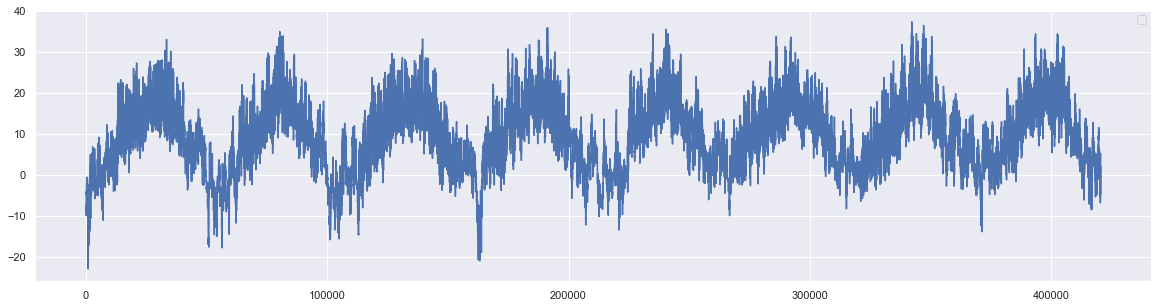

In [5]:
#The plot represents temperature variation over  given time range
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(dataframe["T (degC)"])
plt.legend();

In [7]:
#setting the parameters
split_fraction = 0.715
train_split = int(split_fraction * int(dataframe.shape[0]))
step = 6

past = 720
future = 72
#learning_rate = 0.001
#batch_size = 256
#epochs = 10


#function for normalization
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [8]:
#function for saving the mean and std deviation of the training dataset as this will be needed for inverse transformation 
def meanst(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return data_mean, data_std


In [9]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]


date_time_key = "Date Time"

In [11]:

print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

#selecting features that are not correlated to each other
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = dataframe[selected_features]
features.index = dataframe[date_time_key]
features.head()

m, std = meanst(features.values,train_split)


#scaling the features to the same scale
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()


#splitting the data using a fraction of 71.5%
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [12]:
#savving the mean and standard deviation of the train dataset to use it later for inverse transformation

dff = pd.DataFrame(m)
dff.head()
dff.columns =['Mean']
dff['Std Dev']=std
dff.to_csv(r"MeanStd_Anomaly.csv",index=False)

In [13]:


X_train = train_data[[i for i in range(7)]].values
X_test = val_data[[i for i in range(7)]].values


In [14]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (300693, 1, 7)
Test data shape: (119858, 1, 7)


In [15]:

# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [16]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1536      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [17]:
# fit the model to the data
#nb_epochs = 1
#batch_size = 10
history = model.fit(X_train, X_train, epochs=1, batch_size=10,
                    validation_split=0.05).history

28566/28566 [==============================] - 104s 4ms/step - loss: 0.2116 - val_loss: 0.1655


c:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

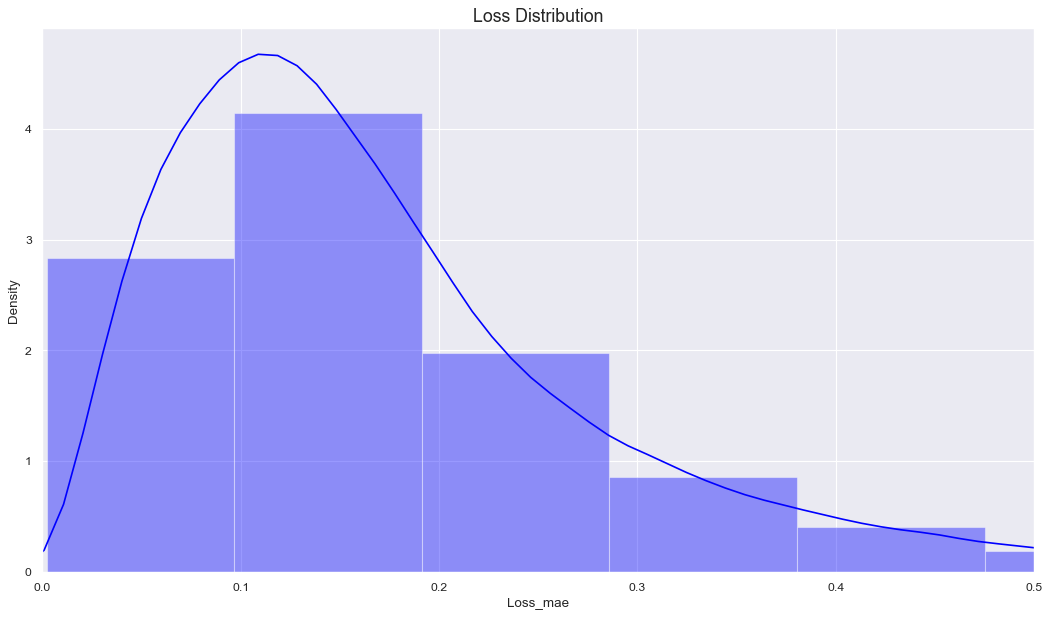

In [24]:

# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
#X_pred = pd.DataFrame(X_pred, columns=train.columns)
#X_pred.index = train.index

scored = pd.DataFrame(index=train_data.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

# plot the loss distribution of the training set - to help us decide on the threshold to keep for detecting anamolies


In [25]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=val_data.columns)
X_pred.index = val_data.index

scored = pd.DataFrame(index=val_data.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.38
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
300693,0.105248,0.38,False
300694,0.158023,0.38,False
300695,0.134652,0.38,False
300696,0.131414,0.38,False
300697,0.046488,0.38,False


In [26]:
#save the model to your local machine and then push it to Git

model.save('AnomalyDetection.h5')

<AxesSubplot:>

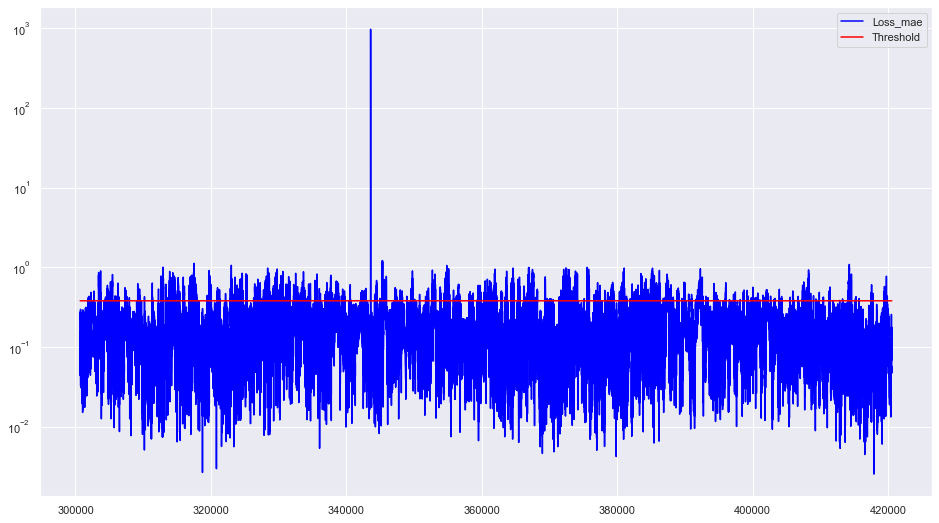

In [27]:
#plot the loss (mean absolute error) for the validation dataset along with the set threshold - helps us to visualize at which rows of the
#validation dataset the loss crosses the threshold - indicating an anamoly
scored.plot(logy=True,  figsize=(16,9), color=['blue','red'])


In [28]:
# Anomalies"""

anomalies = scored[scored['Anomaly']== True]
anomalies.head()

anomalies.shape

(9676, 3)

In [29]:
anomalies['Temperature']=val_data[1]

C:\Users\harsh\AppData\Local\Temp/ipykernel_3752/3512689350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['Temperature']=val_data[1]


In [30]:
dft = dff.iloc[2,:]
mean = dft['Mean']

std = dft['Std Dev']


In [31]:

def mak(col):
    return (col*std + mean)

anomalies['Temperature'] = anomalies['Temperature'].apply(mak)

C:\Users\harsh\AppData\Local\Temp/ipykernel_3752/1962978625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['Temperature'] = anomalies['Temperature'].apply(mak)


In [32]:

val_data[1] = val_data[1].apply(mak)

C:\Users\harsh\AppData\Local\Temp/ipykernel_3752/2917776745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data[1] = val_data[1].apply(mak)


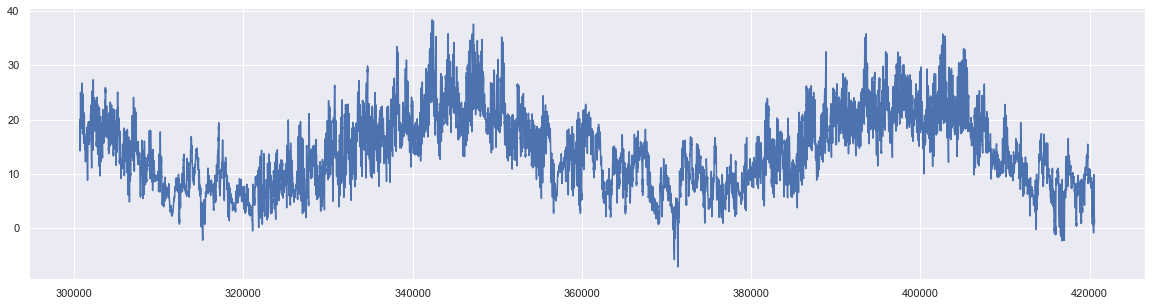

In [33]:

#plot the variation of temperature for the validation dataset
plt.plot(
  val_data.index, 
  val_data[1], 
  label='Temp'
);

c:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


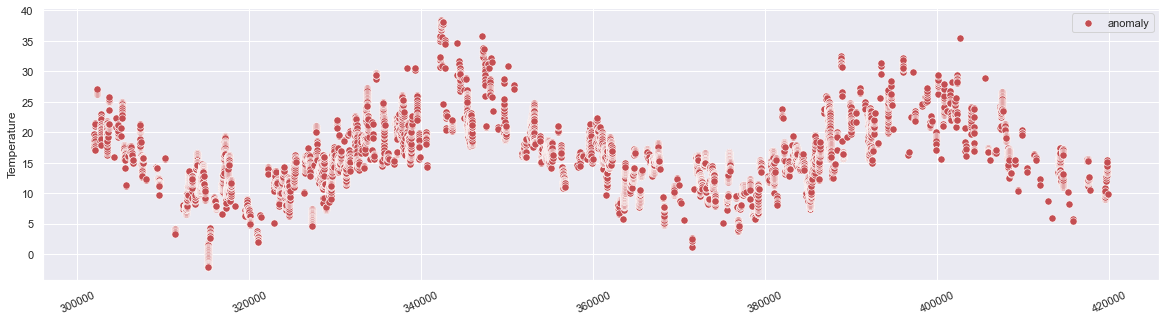

In [34]:
#plot the anomalies for the validation datatset - as seen it comes for some of the rows of the validation dataset

sns.scatterplot(
  anomalies.index,
  anomalies['Temperature'],
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();